In this Notebook, each travelling salesmen has a different start location and has a cost.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import itertools


### Initialize the problem

In [2]:
numPoints = 20

# Generate random locations
X = []
Y = []

for i in range(numPoints):
    X.append(random.uniform(0,100))
    Y.append(random.uniform(0,100))
    

In [3]:
# Locations in a dataframe
df = pd.DataFrame()
df['ID'] = list(np.arange(1,numPoints+1))
df['X'] = X
df['Y'] = Y

# Put locations in a list
locations = list(df['ID'])


In [4]:
# Distance matrix
distance_matrix = []

for i in range(df.shape[0]):
    row = []
    
    for j in range(df.shape[0]):
        distance = np.sqrt((df['X'].iloc[i] - df['X'].iloc[j])**2 + (df['Y'].iloc[i] - df['Y'].iloc[j])**2)
        row.append(distance)
        
    distance_matrix.append(row)
    
# Make a copy of the distance matrix for manipulations
distance_matrix_copy = copy.deepcopy(distance_matrix)
distance_matrix_plot = copy.deepcopy(distance_matrix)
    

In [5]:
# Color dictionary to plot the solution
numbers = []
colors = []

for i in range(len(list(mcolors.CSS4_COLORS))):
    numbers.append(i)
 
# for bigger problems
colors = list(mcolors.CSS4_COLORS)
# for smaller problems
colors = list(mcolors.BASE_COLORS)

# Convert lists to dictionary
color_dict = {}
for key in numbers:
    for value in colors:
        color_dict[key] = value
        colors.remove(value)
        break


### Problem Setup

In [6]:
# number of salesmen
SALESMEN = 5

# cost per salesman
SALESMEN_COST = 500

locations_copy = copy.deepcopy(locations)

# routes for the salesmen
res = []
START_LOCATIONS = []

for i in range(SALESMEN):
    start_location = random.sample(locations_copy, k=1)[0]
    START_LOCATIONS.append(start_location)
    locations_copy.remove(start_location)
    res.append([start_location,start_location])


In [7]:
names = []

for i in range(df.shape[0]):
    if df['ID'].iloc[i] in START_LOCATIONS:
        names.append('Start')
    else:
        names.append(i+1)

df['NAME'] = names


In [8]:
# Create random intial route
for i in range(len(locations_copy)):
    
    # Route to insert
    insertion = random.sample(list(range(1,SALESMEN+1)), k=1)[0]
    
    # Select a random location to insert
    random_location = random.sample(locations_copy, k=1)[0]
    locations_copy.remove(random_location)

    # Select a random spot to insert
    random_spot = random.sample(range(1,len(res[insertion-1])),k=1)[0]
    res[insertion-1].insert(random_spot,random_location)


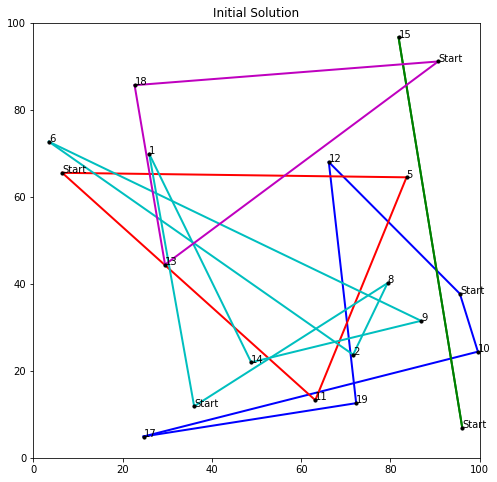

In [9]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=2)
            
plt.title('Initial Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


### Solving the problem

Find the shortest route by using as little number of salesmen.

In [10]:
locations_copy = copy.deepcopy(locations)

for i in range(SALESMEN):
    locations_copy.remove(res[i][0])


In [11]:
### Branch-and-cut Solution

# Develeopment of the solution
history = []

# shortest distance
shortest_route = [0]*SALESMEN

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        shortest_route[i] += SALESMEN_COST
        
# Objective
objective = sum(shortest_route)
history.append(objective)

print(res)
print('Lengths of the routes:', shortest_route)
print('Objective initial solution:', objective)


[[3, 10, 17, 19, 12, 3], [16, 15, 16], [4, 11, 5, 4], [20, 8, 2, 6, 9, 14, 1, 20], [7, 18, 13, 7]]
Lengths of the routes: [737.5192491038447, 681.8849087190385, 709.4139547688753, 898.1218152457398, 687.0190903002485]
Objective initial solution: 3713.959018137747


In [12]:
# Initial solution
print(res)
print('Lengths of the routes:', shortest_route)
print('Current best solution:', objective)
print()

for tries in range(10000):

    # maximum number of locations to remove
    max_removes = int(np.round(len(locations)/2))

    # make a copy of the current route
    res_interim = copy.deepcopy(res)
    res_interim

    # locations to remove (at least 1)
    number = random.sample(range(1,max_removes), 1)[0]
    loc_remove = random.sample(locations_copy, number)
    loc_remove

    # remove locations from route
    for loc in (loc_remove):   
        for i in range(len(res_interim)):
            if loc in res_interim[i]:
                res_interim[i].remove(loc)

    # randomly insert locations into result
    for loc in (loc_remove):
        # Route to insert
        insertion = random.sample(range(1,SALESMEN+1), k=1)[0]

        insert_position = np.random.randint(1,len(res_interim[insertion-1]))
        res_interim[insertion-1].insert(insert_position, loc)

    current_route_interim = [0]*SALESMEN

    for i in range(len(res_interim)):
        for j in range(len(res_interim[i])-1):
            current_route_interim[i] += distance_matrix_copy[res_interim[i][j]-1][res_interim[i][j+1]-1]
        if len(res_interim[i]) > 2:
            current_route_interim[i] += SALESMEN_COST

    current_objective = sum(current_route_interim)

    if current_objective < objective:
        objective = current_objective
        res = res_interim

    history.append(objective)

print(res)

# Objective
shortest_route = [0]*SALESMEN

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        shortest_route[i] += SALESMEN_COST
        
print('Lengths of the routes:', shortest_route)
print('Objective:', objective)


[[3, 10, 17, 19, 12, 3], [16, 15, 16], [4, 11, 5, 4], [20, 8, 2, 6, 9, 14, 1, 20], [7, 18, 13, 7]]
Lengths of the routes: [737.5192491038447, 681.8849087190385, 709.4139547688753, 898.1218152457398, 687.0190903002485]
Current best solution: 3713.959018137747

[[3, 3], [16, 16], [4, 18, 1, 13, 2, 8, 9, 10, 5, 15, 12, 6, 4], [20, 17, 11, 19, 14, 20], [7, 7]]
Lengths of the routes: [0.0, 0.0, 837.5999272052541, 603.4741621887363, 0.0]
Objective: 1441.0740893939903


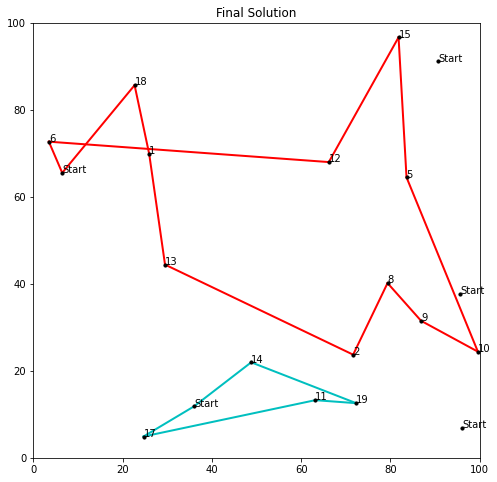

In [13]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=2)
            
plt.title('Final Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


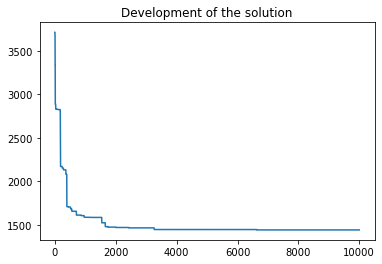

In [14]:
plt.plot(history)
plt.title('Development of the solution')
plt.show()
